#### Setup & Installation

In [5]:
!pip install -r requirements.txt

  Using cached tensorflow-2.19.0-cp312-cp312-win_amd64.whl.metadata (4.1 kB)
  Using cached librosa-0.11.0-py3-none-any.whl.metadata (8.7 kB)
  Using cached scikit_learn-1.6.1-cp312-cp312-win_amd64.whl.metadata (15 kB)
  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
  Using cached scipy-1.15.3-cp312-cp312-win_amd64.whl.metadata (60 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
  Using cached pycparser-2.22-py3-none-any.whl.metadata (943 bytes)
   ---------------------------------------- 0.0/376.0 MB ? eta -:--:--
   ---------------------------------------- 0.3/376.0 MB ? eta -:--:--
   ---------------------------------------- 0.8/376.0 MB 3.3 MB/s eta 0:01:53
   ---------------------------------------- 1.6/376.0 MB 3.0 MB/s eta 0:02:06
   ---------------------------------------- 2.9/376.0 MB 4.3 MB/s eta 0:01:27
   ---------------------------------------- 2.9/376.0 MB 4.3 MB/s eta 0:01:27
   ---------------------------------------- 2.9/376.0

### Import Required Libraries

In [25]:
import os
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder , StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping 
from pydub import AudioSegment
import warnings
warnings.filterwarnings("ignore")

### Load and preprocess Dataset

In [26]:
def load_dataset(dataset_path):
    features = []
    labels = []
    for file in os.listdir(dataset_path):
        if file.endswith(".wav"):
            emotion_code = int(file.split("-")[2])
            # Map emotion codes to actual emotions (RAVDESS-specific)
            emotions = {
                1: "neutral", 2: "calm", 3: "happy", 4: "sad", 
                5: "angry", 6: "fearful", 7: "disgust", 8: "surprised"
            }
            emotion = emotions.get(emotion_code, "unknown")
            file_path = os.path.join(dataset_path, file)
            mfccs = extract_features(file_path)
            if mfccs is not None:
                features.append(mfccs)
                labels.append(emotion)
    return np.array(features), np.array(labels)

#### Feature Extraction

In [27]:
def extract_features(file_path , max_pad_len = 400):
    try:
        audio, sr = librosa.load(file_path, sr=None)
        mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)
        pad_width = max_pad_len - mfccs.shape[1]
        if pad_width > 0:
            mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
        else:
            mfccs = mfccs[:, :max_pad_len]
        return mfccs
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

    

In [28]:
import zipfile
import os

# Corrected paths (using raw string)
zip_path = r"D:\Code Alpha\P2\03-01-06-02-01-12.zip"
extract_path = r"D:\Code Alpha\P2\dataset"

# Verify zip exists
if not os.path.exists(zip_path):
    raise FileNotFoundError(f"ZIP file not found at: {zip_path}")

# Create extraction directory
os.makedirs(extract_path, exist_ok=True)

# Extract with error handling
try:
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        print(f"Extracting to {extract_path}...")
        zip_ref.extractall(extract_path)
        print(f"Extracted {len(zip_ref.namelist())} files")
except zipfile.BadZipFile:
    print("Error: File is not a valid ZIP archive")
except Exception as e:
    print(f"Error during extraction: {str(e)}")

# Verify extraction
if not os.listdir(extract_path):
    print("Warning: No files were extracted!")
else:
    print(f"Found {len(os.listdir(extract_path))} files in destination")

Extracting to D:\Code Alpha\P2\dataset...
Extracted 1036 files
Found 24 files in destination


### Data Preparation

In [30]:
dataset_path = "D:\\Code Alpha\\P2\\dataset"
X, y = load_dataset(dataset_path)

### Encode Labels and split data

In [ ]:
import os
import numpy as np
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical


dataset_path = "D:\\Code Alpha\\P2\\dataset\\Actor_01"
print("Files in dataset:", os.listdir(dataset_path)[:5]) 

# Load dataset
X, y = load_dataset(dataset_path)

# Check if data is loaded
if len(X) == 0 or len(y) == 0:
    raise ValueError("No data loaded. Check if: (1) Path is correct, (2) Files are .wav, (3) Emotion labels exist.")

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
print("Unique labels:", np.unique(y_encoded))  # Debug: Should print [0, 1, 2, ...]

# Convert to categorical
y_categorical = to_categorical(y_encoded)
print("Categorical labels shape:", y_categorical.shape)  # Should be (n_samples, n_classes)

Files in dataset: ['03-02-01-01-01-01-01.wav', '03-02-01-01-01-02-01.wav', '03-02-01-01-02-01-01.wav', '03-02-01-01-02-02-01.wav', '03-02-02-01-01-01-01.wav']
Unique labels: [0 1 2 3 4 5]
Categorical labels shape: (44, 6)


In [34]:
# Encode emotions to integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

# Split into train & test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42)

# Reshape for CNN input (samples, timesteps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

### Build the CNN + LSTM Model

In [35]:
model = Sequential()
model.add(Conv1D(256, 5, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(MaxPooling1D(3))
model.add(Dropout(0.3))
model.add(Conv1D(128, 3, activation='relu'))
model.add(MaxPooling1D(3))
model.add(Dropout(0.3))
model.add(LSTM(64 , return_sequences=True))
model.add(LSTM(32))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(len(label_encoder.classes_), activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 36, 256)        │       512,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 12, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 128)        │        98,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 3, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 3, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 3, 64)          │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 673,766 (2.57 MB)

 Trainable params: 673,766 (2.57 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [36]:
early_stop = EarlyStopping(monitor='val_loss', patience=5)
history = model.fit(
    X_train, y_train, 
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks = [early_stop]
)

Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 527ms/step - accuracy: 0.2062 - loss: 1.7929 - val_accuracy: 0.3333 - val_loss: 1.7051
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.1664 - loss: 1.8183 - val_accuracy: 0.3333 - val_loss: 1.7057
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.2253 - loss: 1.7945 - val_accuracy: 0.2222 - val_loss: 1.7216
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.1074 - loss: 1.8118 - val_accuracy: 0.3333 - val_loss: 1.7109
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.2062 - loss: 1.7960 - val_accuracy: 0.3333 - val_loss: 1.7224
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.1074 - loss: 1.8114 - val_accuracy: 0.1111 - val_loss: 1.7391


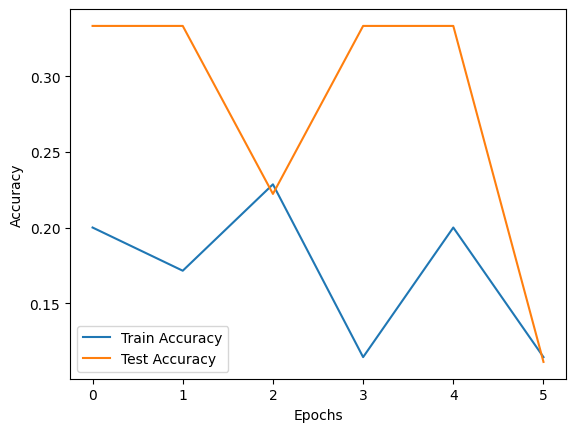

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.1111 - loss: 1.7391
Test Accuracy: 11.11%


In [37]:
# Plot training history
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluate on test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

In [43]:
def predict_emotion(file_path):
    mfccs = extract_features(file_path)
    if mfccs is None:
        return "Error processing file"
    mfccs = mfccs.reshape(1, mfccs.shape[0], mfccs.shape[1], 1)
    prediction = model.predict(mfccs)
    predicted_label = label_encoder.inverse_transform([np.argmax(prediction)])
    return predicted_label[0]

# Example usage
file_path = "D:\\Code Alpha\\P2\\dataset\\Actor_24\\03-02-06-02-02-02-24.wav"
print(f"Predicted Emotion: {predict_emotion(file_path)}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Predicted Emotion: fearful


In [45]:
def predict_emotion(file_path1):
    mfccs = extract_features(file_path1)
    if mfccs is None:
        return "Error processing file"
    mfccs = mfccs.reshape(1, mfccs.shape[0], mfccs.shape[1], 1)
    prediction = model.predict(mfccs)
    predicted_label = label_encoder.inverse_transform([np.argmax(prediction)])
    return predicted_label[0]

# Example usage
file_path1 = "D:\\Code Alpha\\P2\\dataset\\Actor_02\\03-02-01-01-01-01-02.wav"
print(f"Predicted Emotion: {predict_emotion(file_path1)}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Predicted Emotion: happy
